## Imports

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# We'll get some metrics from Scikit-Learn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    f1_score,
    roc_auc_score
)

# To split a validation set off from the train set
from sklearn.model_selection import train_test_split

# ViT is a huggingface model, so it needs a datasets.Dataset for input data
from datasets import (
    Dataset, 
    Image, 
    ClassLabel, 
    load_metric # we'll use this to get the accuracy metric
)

# Grab the necessary modules from huggingface for training ViT
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
)

# Import PyTorch for deep learning
import torch 

# Ignore warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preprocessing
We'll use the following label mapping:

- 0: Fake
- 1: Real

In [2]:
path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'

In [3]:
# Grab the lists of filenames and add their full paths
fake_train = [(path + '/train/FAKE/' + filename) for filename in os.listdir(path + '/train/FAKE')]
real_train = [(path + '/train/REAL/' + filename) for filename in os.listdir(path + '/train/REAL')]

fake_test = [(path + '/test/FAKE/' + filename) for filename in os.listdir(path + '/test/FAKE')]
real_test = [(path + '/test/REAL/' + filename) for filename in os.listdir(path + '/test/REAL')]

fake_train[:3]

['/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/5387 (6).jpg',
 '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/4093 (7).jpg',
 '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/5357 (8).jpg']

We'll start by putting them into pandas DataFrames with their correct labels. We'll also need to add the directory path back in

In [4]:
df_train = pd.DataFrame({
    'image': fake_train + real_train,
    'label': ([0] * len(fake_train)) + ([1] * len(real_train))
})

df_test = pd.DataFrame({
    'image': fake_test + real_test,
    'label': ([0] * len(fake_test)) + ([1] * len(real_test))
})

df_train.head()

,image,label
0,/kaggle/input/cifake-real-and-ai-generated-syn...,0
1,/kaggle/input/cifake-real-and-ai-generated-syn...,0
2,/kaggle/input/cifake-real-and-ai-generated-syn...,0
3,/kaggle/input/cifake-real-and-ai-generated-syn...,0
4,/kaggle/input/cifake-real-and-ai-generated-syn...,0


We need to split off a chunk of the train set for validation during training

In [5]:
df_train, df_val = train_test_split(df_train,
                                    test_size=0.1,
                                    shuffle=True, 
                                    stratify=df_train['label'], 
                                    random_state=0)

df_val.head()

,image,label
336,/kaggle/input/cifake-real-and-ai-generated-syn...,0
72052,/kaggle/input/cifake-real-and-ai-generated-syn...,1
22448,/kaggle/input/cifake-real-and-ai-generated-syn...,0
19381,/kaggle/input/cifake-real-and-ai-generated-syn...,0
64089,/kaggle/input/cifake-real-and-ai-generated-syn...,1


Let's make sure it was split and stratified properly

In [6]:
print(df_train.shape)
print(df_val.shape)

df_train['label'].value_counts()

(90000, 2)
(10000, 2)


label
1    45000
0    45000
Name: count, dtype: int64

In [7]:
# This is a nifty way to replace the paths with images that DIMA806 did in this notebook:
# https://www.kaggle.com/code/dima806/cifake-ai-generated-image-detection-vit

ds_train = Dataset.from_pandas(df_train).cast_column('image', Image())
ds_val = Dataset.from_pandas(df_val).cast_column('image', Image())
ds_test = Dataset.from_pandas(df_test).cast_column('image', Image())

Let's look at an example image

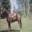

In [8]:
example = ds_train[0]
example['image']

The images in CIFAKE were scaled down to 32x32 for faster training. But is this one real or fake?

In [9]:
label_names = ['Fake', 'Real']

In [10]:
label_names[example['label']]

'Real'

Professor Jason Yoder wrote a nice function to view a grid of images with their labels. Let's use it here

In [11]:
def plot_images(num_img, rows, cols, images, labels, label_names):
    plt.figure(figsize=(rows * 2, cols * 2))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(label_names[labels[i]])

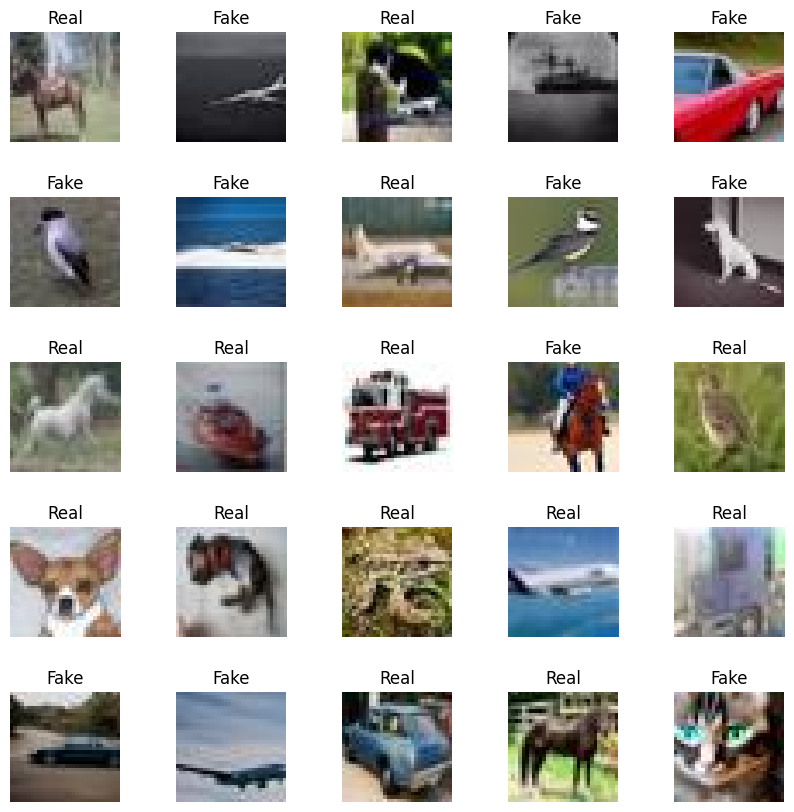

In [12]:
plot_images(25, 5, 5, ds_train[:25]['image'], ds_train[:25]['label'], label_names)

# Data Preprocessing

In [13]:
pretrained_model = 'google/vit-base-patch16-224-in21k'

In [14]:
processor = ViTImageProcessor.from_pretrained(pretrained_model)

In [15]:
def transform(batch):
    # Take a list of PIL images
    inputs = processor([x for x in batch['image']], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

In [16]:
ds_train.set_transform(transform)
ds_val.set_transform(transform)
ds_test.set_transform(transform)

In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [18]:
metric = load_metric("accuracy")

def compute_metrics(p):
    # We'll just return the accuracy
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [19]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label_names),
    id2label={str(i): c for i, c in enumerate(label_names)},
    label2id={c: str(i) for i, c in enumerate(label_names)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir='./vit-cifake',
    logging_dir='./logs',
    
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    fp16=True,
    
    evaluation_strategy="epoch",
    save_strategy='epoch',
    save_total_limit=1,
    
    num_train_epochs=10,
    learning_rate=1e-4,
    
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=processor,
)

In [22]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.095400,0.038305,0.986200
2,0.040400,0.093295,0.976900
3,0.040400,0.096929,0.988700
4,0.038000,0.099859,0.990700
5,0.021300,0.106813,0.991000
6,0.014100,0.089823,0.992800
7,0.008700,0.141840,0.989500
8,0.002000,0.105489,0.992900
9,0.000000,0.103385,0.993100
10,0.000000,0.104836,0.992800


***** train metrics *****
  epoch                    =          10.0
  total_flos               = 64953035351GF
  train_loss               =        0.0236
  train_runtime            =    7:45:31.68
  train_samples_per_second =        32.221
  train_steps_per_second   =         0.252


In [32]:
# Get the trainer's log history
train_state = trainer.state.log_history

results = pd.DataFrame(train_state[:-1])
results = results.set_index('epoch')
results = results[results.index % 1 == 0]
results

,loss,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,
1.0,NaN,NaN,704,0.038305,0.9862,246.4201,40.581,0.321,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,1408,0.093295,0.9769,170.0913,58.792,0.464,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,2112,0.096929,0.9887,168.8195,59.235,0.468,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,2816,0.099859,0.9907,170.0153,58.818,0.465,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,3520,0.106813,0.9910,168.5838,59.318,0.469,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,4224,0.089823,0.9928,169.2486,59.085,0.467,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,4928,0.141840,0.9895,171.8975,58.174,0.460,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,5632,0.105489,0.9929,169.1715,59.112,0.467,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,6336,0.103385,0.9931,168.0038,59.522,0.470,NaN,NaN,NaN,NaN,NaN


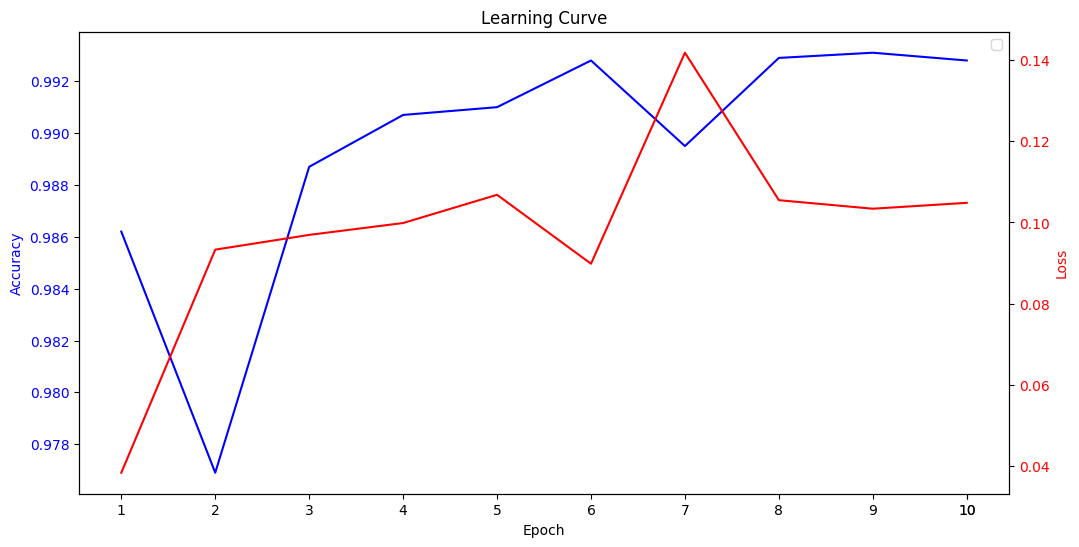

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot evaluation accuracy on the primary axis (ax1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy', color='blue')
ax.plot(results.index, results['eval_accuracy'], color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax.set_xticks(results.index)

# Create a secondary axis (twinx) for evaluation loss
ax2 = ax.twinx()

# Plot evaluation loss on the secondary axis (ax2)
ax2.set_ylabel('Loss', color='red')
ax2.plot(results.index, results['eval_loss'], color='red')
ax2.tick_params(axis='y', labelcolor='red')


# Set plot title
plt.title('Learning Curve')

plt.legend()
plt.show()

In [25]:
metrics = trainer.evaluate(ds_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9865
  eval_loss               =     0.0388
  eval_runtime            = 0:07:51.03
  eval_samples_per_second =      42.46
  eval_steps_per_second   =      0.333


In [26]:
predictions = trainer.predict(ds_test)

y_true = df_test['label']
y_pred = predictions.predictions.argmax(axis=1)

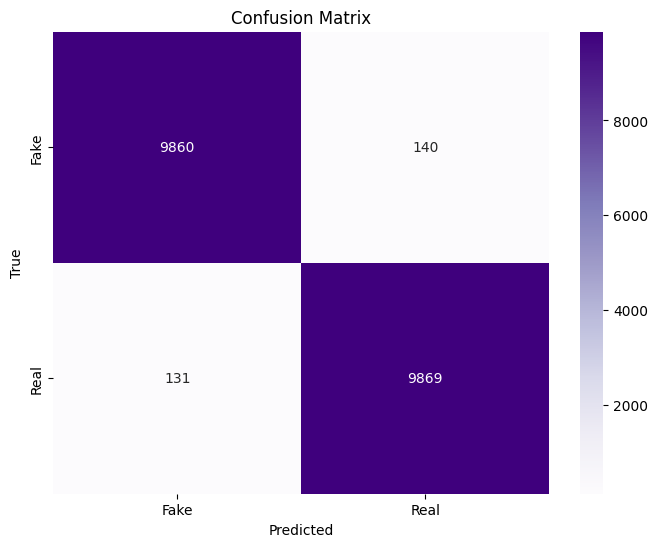

In [27]:
confusion = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Purples', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

In [28]:
print('F1 Score:', f1_score(y_true, y_pred))
print('ROC AUC Score:', roc_auc_score(y_true, y_pred))

F1 Score: 0.9864560947573592
ROC AUC Score: 0.9864499999999999


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10000
           1       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

